# Importação e análise inicial dos dados

In [73]:
#libraries
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn import cluster


In [74]:
data = sns.load_dataset("iris")

In [75]:
iris = data

In [76]:
iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [77]:
iris.describe().T

,count,mean,std,min,25%,50%,75%,max
sepal_length,150.0,5.843333,0.828066,4.3,5.1,5.80,6.4,7.9
sepal_width,150.0,3.057333,0.435866,2.0,2.8,3.00,3.3,4.4
petal_length,150.0,3.758000,1.765298,1.0,1.6,4.35,5.1,6.9
petal_width,150.0,1.199333,0.762238,0.1,0.3,1.30,1.8,2.5


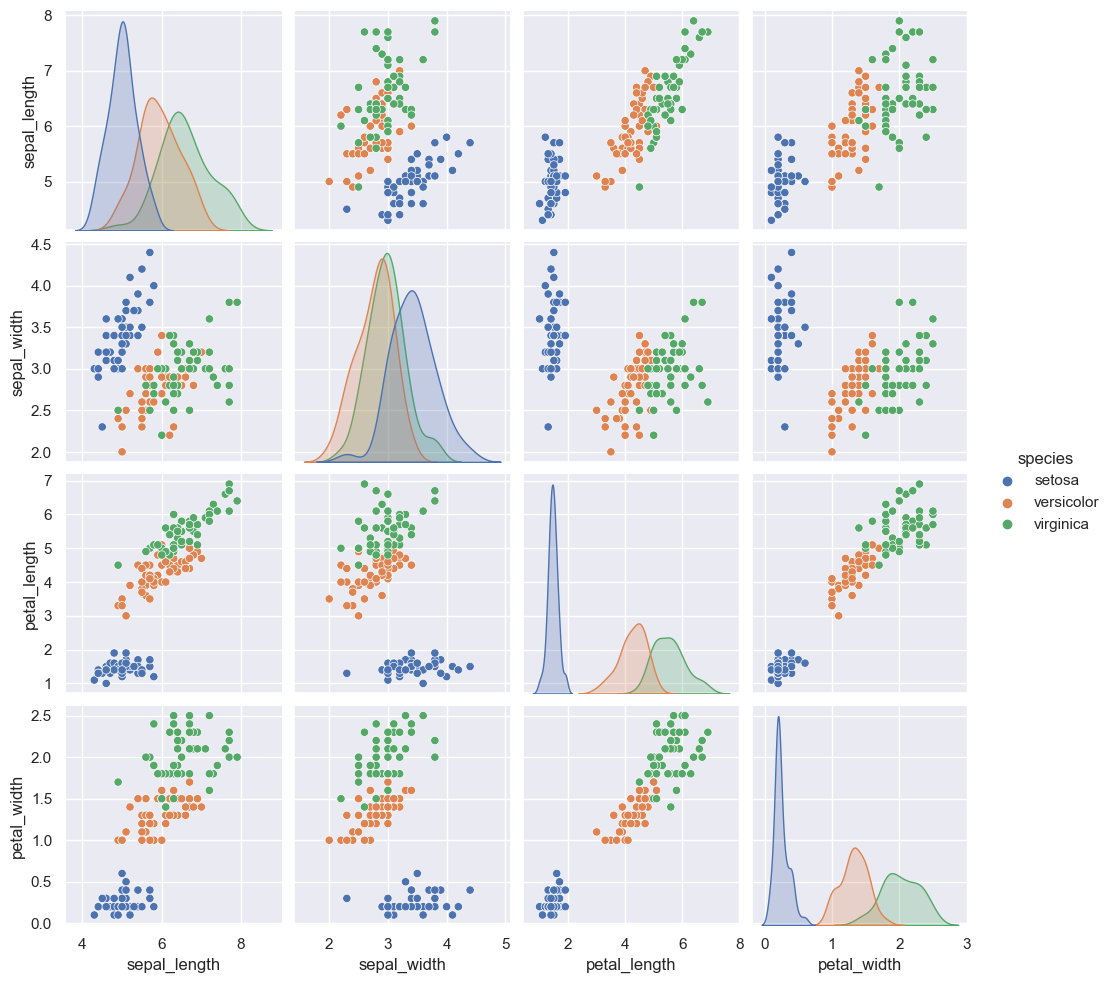

In [78]:
sns.pairplot(iris, hue="species")

<AxesSubplot: xlabel='sepal_length', ylabel='sepal_width'>

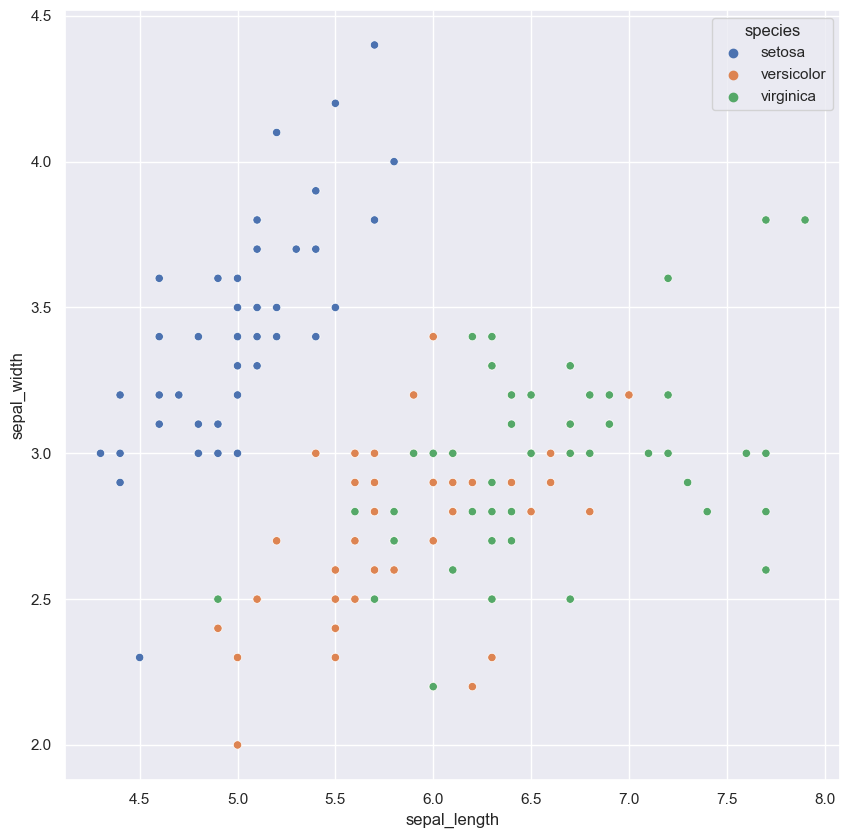

In [79]:
# Plot da classificação Original com todos os pontos.

fig, (axe1) = plt.subplots(1 ,figsize=(10,10))

sns.scatterplot(data=iris, x='sepal_length', y='sepal_width', hue='species', ax=axe1)



# Classificação com Teste e Erros

In [80]:
# Definir porcentagem de dados utilizado para teste, número de grupos e legenda correta de agrupamento, caso exista ( para cálculo de erro no final.)
PorcentTeste = 10
numGrupos = 3
legenda_agrupamento = 'species'

# Definir Características utilizadas na classificação
selected_var = [ 'sepal_width', 'petal_length', 'petal_width']

# Defino tamanho do teste
tamData =len(data)
numLinTeste = int(tamData * (PorcentTeste / 100))
print(" Número de objetos de teste: " , numLinTeste)


 Número de objetos de teste:  15


In [81]:
# Crio função para obter lista de indexes pseudo-aleatórios para serem usados em teste, garantindo não repetição.
def getRandomIndexes(all_index,numLinTeste):
  random_Test_indexes = []
  for x in range(numLinTeste):
    tmp_int = np.random.choice(all_index, size = 1)
    all_index.remove(tmp_int[0])
    random_Test_indexes.append( tmp_int[0] )
  return random_Test_indexes

In [82]:
# Separo variáveis utilizadas para classificação, exceto 'species'
iris_data = data[ selected_var + ['species']]
# Obtenho Linha de indexes randômicos.
all_index = iris_data.index.values.tolist()
random_Test_indexes = getRandomIndexes(all_index, numLinTeste)
# Separo DataFrames de Teste e Treino, além de armazenar agrupamento original do segmento de teste.
iris_data_Teste = iris_data.iloc[ random_Test_indexes ] 
iris_data_Treino = iris_data.drop(random_Test_indexes , axis = 0)
Agrupamento_original_treino = iris_data_Treino['species']
iris_data_Treino.drop(['species' ],axis = 1,inplace = True)
Agrupamento_original_teste = iris_data_Teste['species']
iris_data_Teste.drop(['species' ],axis = 1,inplace = True)

print(" Indexes de Teste: ")
print(random_Test_indexes)


 Indexes de Teste: 
[31, 68, 12, 116, 40, 73, 142, 98, 139, 80, 77, 95, 14, 22, 93]


C:\Users\AbraaoCG\AppData\Local\Temp\ipykernel_14948\3027132466.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iris_data_Teste.drop(['species' ],axis = 1,inplace = True)


In [83]:
iris_data.drop('species', axis = 1).to_csv('dataset_treino.txt', sep = '\t', index = False)

In [84]:
kmeans = cluster.KMeans(numGrupos)
clusters = kmeans.fit_predict(iris_data_Treino)
clusters_DF = pd.DataFrame({ 'Agrupamento' :clusters}, index = iris_data_Treino.index)

#clusters_DF.to_csv('agrupamento_iris_Sklearn.txt', sep = '\t' )

headers_df = iris_data_Treino.columns
centroides_Treino = pd.DataFrame( kmeans.cluster_centers_ , columns = headers_df)
x_center, y_center = kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1]


iris_data_Treino_avalia = pd.concat( [iris_data_Treino,clusters_DF ,Agrupamento_original_treino], axis = 1)
iris_data_Treino_avalia

pd.value_counts(clusters_DF['Agrupamento'])


2    53
1    45
0    37
Name: Agrupamento, dtype: int64

In [85]:
# Crio uma tabela para armazenar agrupamento gerado pelo treino e o agrupamento original do segmento de teste.
iris_data_Teste_agrupado = pd.concat ( [iris_data_Teste, Agrupamento_original_teste] , axis = 1)

In [86]:
# Agrupamento dos pontos de teste em função de suas distâncias aos centroides gerados pelo treinamento.
agrup = np.ndarray(len(iris_data_Teste ))
cont = 0
for point in random_Test_indexes:
    sumsquare = 0
    distMin = np.Inf
    for group in range(len(centroides_Treino)):
        sumquadrados = 0
        for dimension in iris_data_Teste:
          sumquadrados += ( iris_data_Teste[dimension][point] - centroides_Treino[dimension][group] ) ** 2
        distancia_PC = np.sqrt(sumquadrados)
        if ( distancia_PC < distMin ):
            distMin = distancia_PC
            agrup[cont] = int(group) 
    cont += 1
agrup_df = pd.DataFrame({ 'Agrupamento' : agrup } , index = random_Test_indexes)
iris_data_Teste_agrupado = pd.concat([iris_data_Teste_agrupado,agrup_df ], axis = 1)
#iris_data_Teste_agrupado

In [95]:
# iris_data_Teste_agrupado

In [88]:
agrup_original = iris_data['species'].to_numpy()
num_objetos_original = pd.value_counts(agrup_original)
type(num_objetos_original)

pandas.core.series.Series

In [89]:
# Para calcular o Erro, posso calcular centroides da classificação original e, assim, realizar uma tentativa de igualar grupos formados com grupos reais.
# Exmp do dataset Iris --> Grupo 0 : 'virgínica' ; Grupo1 : 'Setosa' ; Grupo 2 :  'versicolor'

num_grupos_dataset = numGrupos
# Obtenho lista com nomes de cada tipo de objeto / label.
group_labels = iris_data[legenda_agrupamento].unique()

# Crio dataset para centroide original
Centroide_original = pd.DataFrame( columns = iris_data_Teste.columns , index = group_labels )
Centroide_original.fillna(0.0, inplace = True)

for item in iris_data.index.values: # index do objeto de Teste
  for group in group_labels: # legenda dos grupos
    if ( iris_data[legenda_agrupamento][item] == group):
      for dimension in iris_data_Teste: # legenda das dimensões
        Centroide_original[dimension][group] += iris_data[dimension][item]

Centroide_original = pd.concat([Centroide_original ,pd.DataFrame({ 'numObjetos' : num_objetos_original}) ], axis = 1)

for group in group_labels:
  for dimension in iris_data_Teste:
    Centroide_original[dimension][group] = Centroide_original[dimension][group] / Centroide_original['numObjetos'][group]

#x_center_orig = Centroide_original['sepal_length']
#y_center_orig = Centroide_original['sepal_width']

Centroide_original

C:\Users\AbraaoCG\AppData\Local\Temp\ipykernel_14948\3946320259.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Centroide_original[dimension][group] = Centroide_original[dimension][group] / Centroide_original['numObjetos'][group]


,sepal_width,petal_length,petal_width,numObjetos
setosa,3.428,1.462,0.246,50
versicolor,2.770,4.260,1.326,50
virginica,2.974,5.552,2.026,50


In [90]:
# Equivalencia de Grupo classificado e classificação real.
Centroide_original['Agrupam_correspondencia'] = -1
tmp1 = Centroide_original.drop(columns = ['numObjetos', 'Agrupam_correspondencia'])

for orig_centr in Centroide_original.index.values:
  min_dist = np.Inf
  for classif_centr in centroides_Treino.index.values:
    a = tmp1.loc[[orig_centr]].to_numpy()
    b = centroides_Treino.iloc[[classif_centr]].to_numpy()
    dist_atual = np.linalg.norm( a  - b)
    if ( dist_atual <  min_dist ):
      min_dist = dist_atual
      minDist_label = classif_centr
  Centroide_original['Agrupam_correspondencia'][orig_centr] = minDist_label

print(" Equivalenência estimada entre agrupamento K Means e nome do grupo: ")
Centroide_original['Agrupam_correspondencia']

 Equivalenência estimada entre agrupamento K Means e nome do grupo: 


C:\Users\AbraaoCG\AppData\Local\Temp\ipykernel_14948\2760956773.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Centroide_original['Agrupam_correspondencia'][orig_centr] = minDist_label
C:\Users\AbraaoCG\AppData\Local\Temp\ipykernel_14948\2760956773.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Centroide_original['Agrupam_correspondencia'][orig_centr] = minDist_label
C:\Users\AbraaoCG\AppData\Local\Temp\ipykernel_14948\2760956773.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

setosa        1
versicolor    2
virginica     0
Name: Agrupam_correspondencia, dtype: int64

In [91]:
# Cálculo de erro do Treino, caso seja conhecido o número de grupos original

erros_Treino = []
numErros_Treino = 0
for item in iris_data_Treino_avalia.index.values:
  grupo_item = iris_data_Treino_avalia['species'][item]
  correspondencia_classif = Centroide_original['Agrupam_correspondencia'][ grupo_item ]
  if ( iris_data_Treino_avalia['Agrupamento'][item] != correspondencia_classif ):
    #print(iris_data_Treino_avalia['Agrupamento'][item] , "      " , correspondencia_classif)
    erros_Treino.append(item)
    numErros_Treino += 1
print("Lista de Erros :" , erros_Treino)
print("Números de Erros : " , numErros_Treino)
print( "% de Erros : " , (numErros_Treino / ( tamData- numLinTeste ) ) * 100 , "%")


Lista de Erros : [106, 113, 119, 121, 123, 126, 127, 133, 138, 146]
Números de Erros :  10
% de Erros :  7.4074074074074066 %


In [92]:
# Cálculo de erro do Teste, caso seja conhecido o número de grupos original

erros_Teste = []
numErros_Teste = 0
for item in iris_data_Teste_agrupado.index.values:
  grupo_item = iris_data_Teste_agrupado['species'][item]
  correspondencia_classif = Centroide_original['Agrupam_correspondencia'][ grupo_item ]
  if ( iris_data_Teste_agrupado['Agrupamento'][item] != correspondencia_classif ):
    erros_Teste.append(item)
    numErros_Teste += 1
print("Lista de Erros de Teste :" , erros_Teste)
print("Números de Erros de Teste: " , numErros_Teste)
print("Números de Testes : " , numLinTeste)
if (numLinTeste != 0): print( "% de Erros na testagem : " , (numErros_Teste / numLinTeste) * 100 , "%")

Lista de Erros de Teste : []
Números de Erros de Teste:  0
Números de Testes :  15
% de Erros na testagem :  0.0 %


# Plots da Seção anterior

In [93]:
# Plot dos dados de treino sem classificação
#fig, (axe1) = plt.subplots(figsize=(20,10))
#axe1 = sns.scatterplot(data=iris_data_Treino, x='sepal_length', y='sepal_width', ax = axe1).set(title='Dados de Treino sem classificação' )

#plt.show()


ValueError: Could not interpret value `sepal_length` for parameter `x`

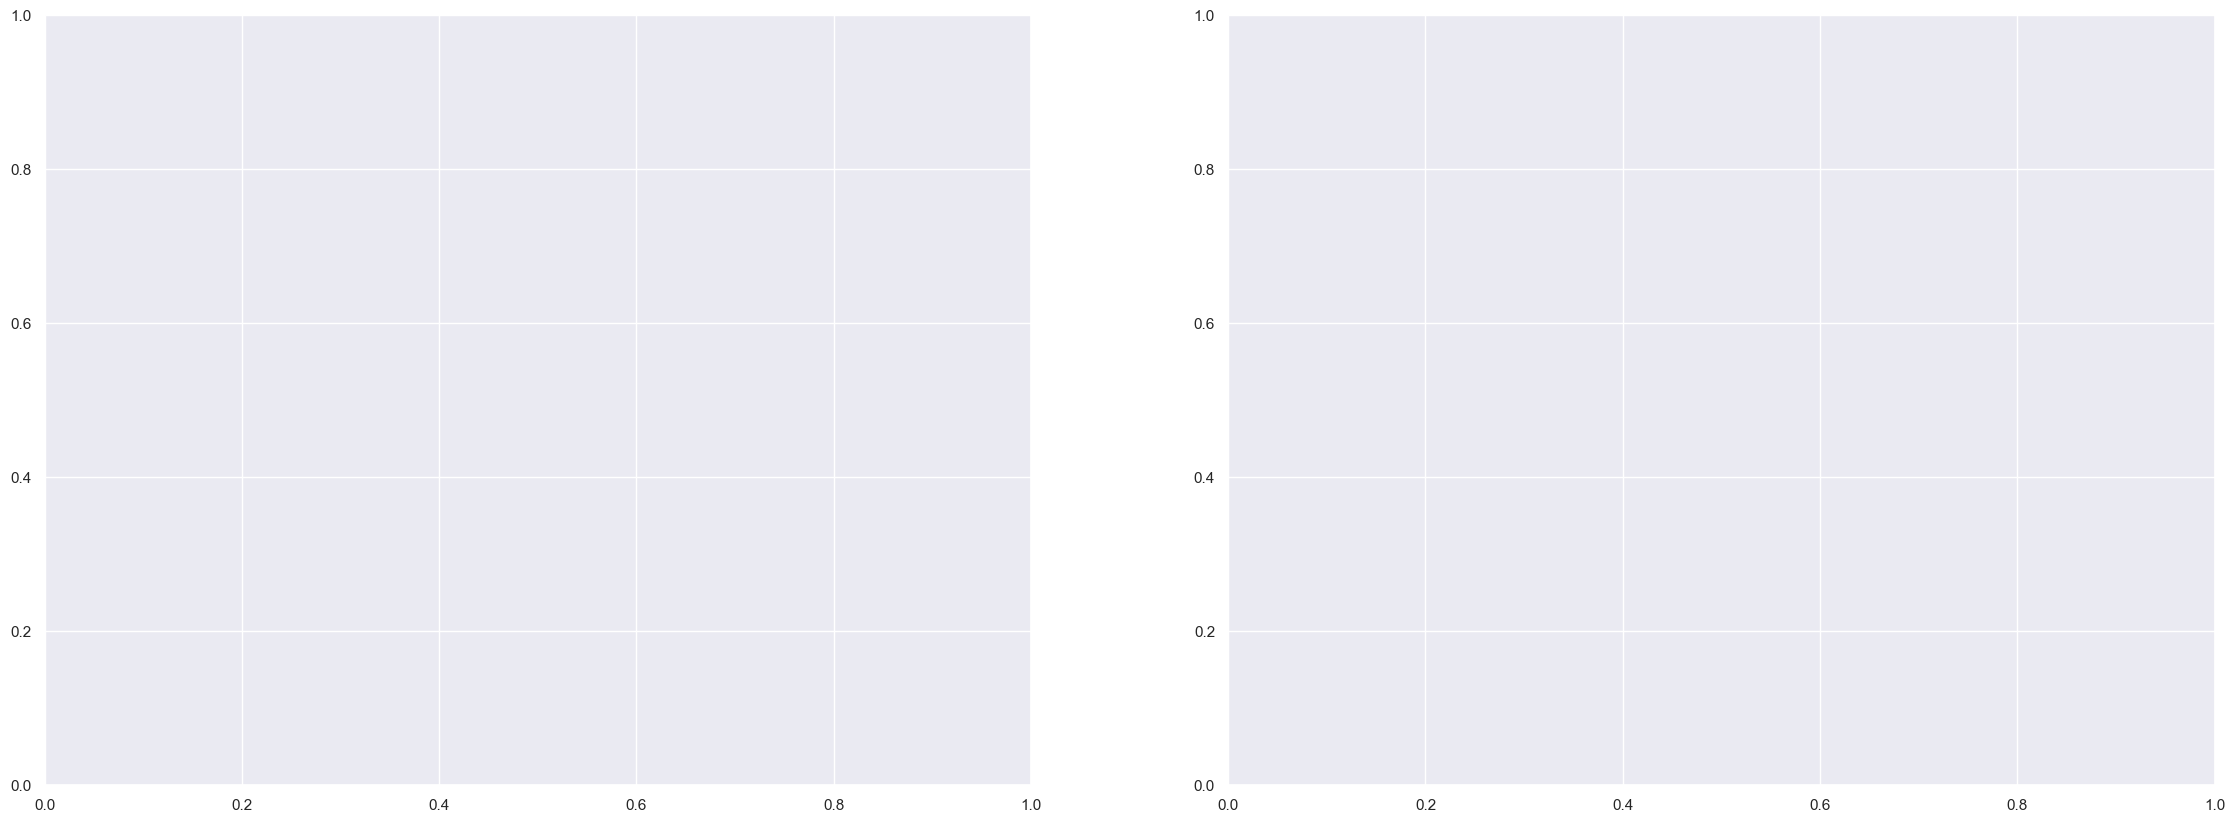

In [94]:
# Plot da classificação do K Means com o segmento de Treino e Plot do dataset original com centroides criados a partir deste.
fig, (axe1, axe2) = plt.subplots(1,2, figsize=(28,10))

sns.scatterplot(data= iris_data_Treino_avalia, x='sepal_length', y='sepal_width', hue='Agrupamento', ax=axe1).set(title='Classificaçao de Treino' )
axe1.scatter(x=x_center, y=y_center, s = 300, color='red')
sns.scatterplot(data= iris_data_Treino_avalia , x='sepal_length', y='sepal_width', hue="species", ax=axe2).set(title='Classificaçao Especialista ')

#axe2.scatter(x=x_center_orig, y=y_center_orig, s = 300, color='green') ----> Centroides dataset Original.
plt.show()

red_pallete_list = []
for agrup in iris_data_Treino_avalia.loc[erros_Treino]['Agrupamento'].unique():
  red_pallete_list.append('red')

fig, (axe1) = plt.subplots(1, figsize=(28,10))
sns.scatterplot(data= iris_data_Treino_avalia, x='sepal_length', y='sepal_width', hue='Agrupamento', ax=axe1).set(title='Classificaçao de Treino' )
axe1.scatter(x=x_center_orig, y=y_center_orig, s = 300, color='green')
sns.scatterplot(data= iris_data_Treino_avalia.loc[erros_Treino], x='sepal_length', y='sepal_width', ax=axe1, hue='Agrupamento' , palette = red_pallete_list ).set(title='Exibicao de erros em vermelho' )


plt.show()


In [ ]:
#iris_data_Teste_agrupado

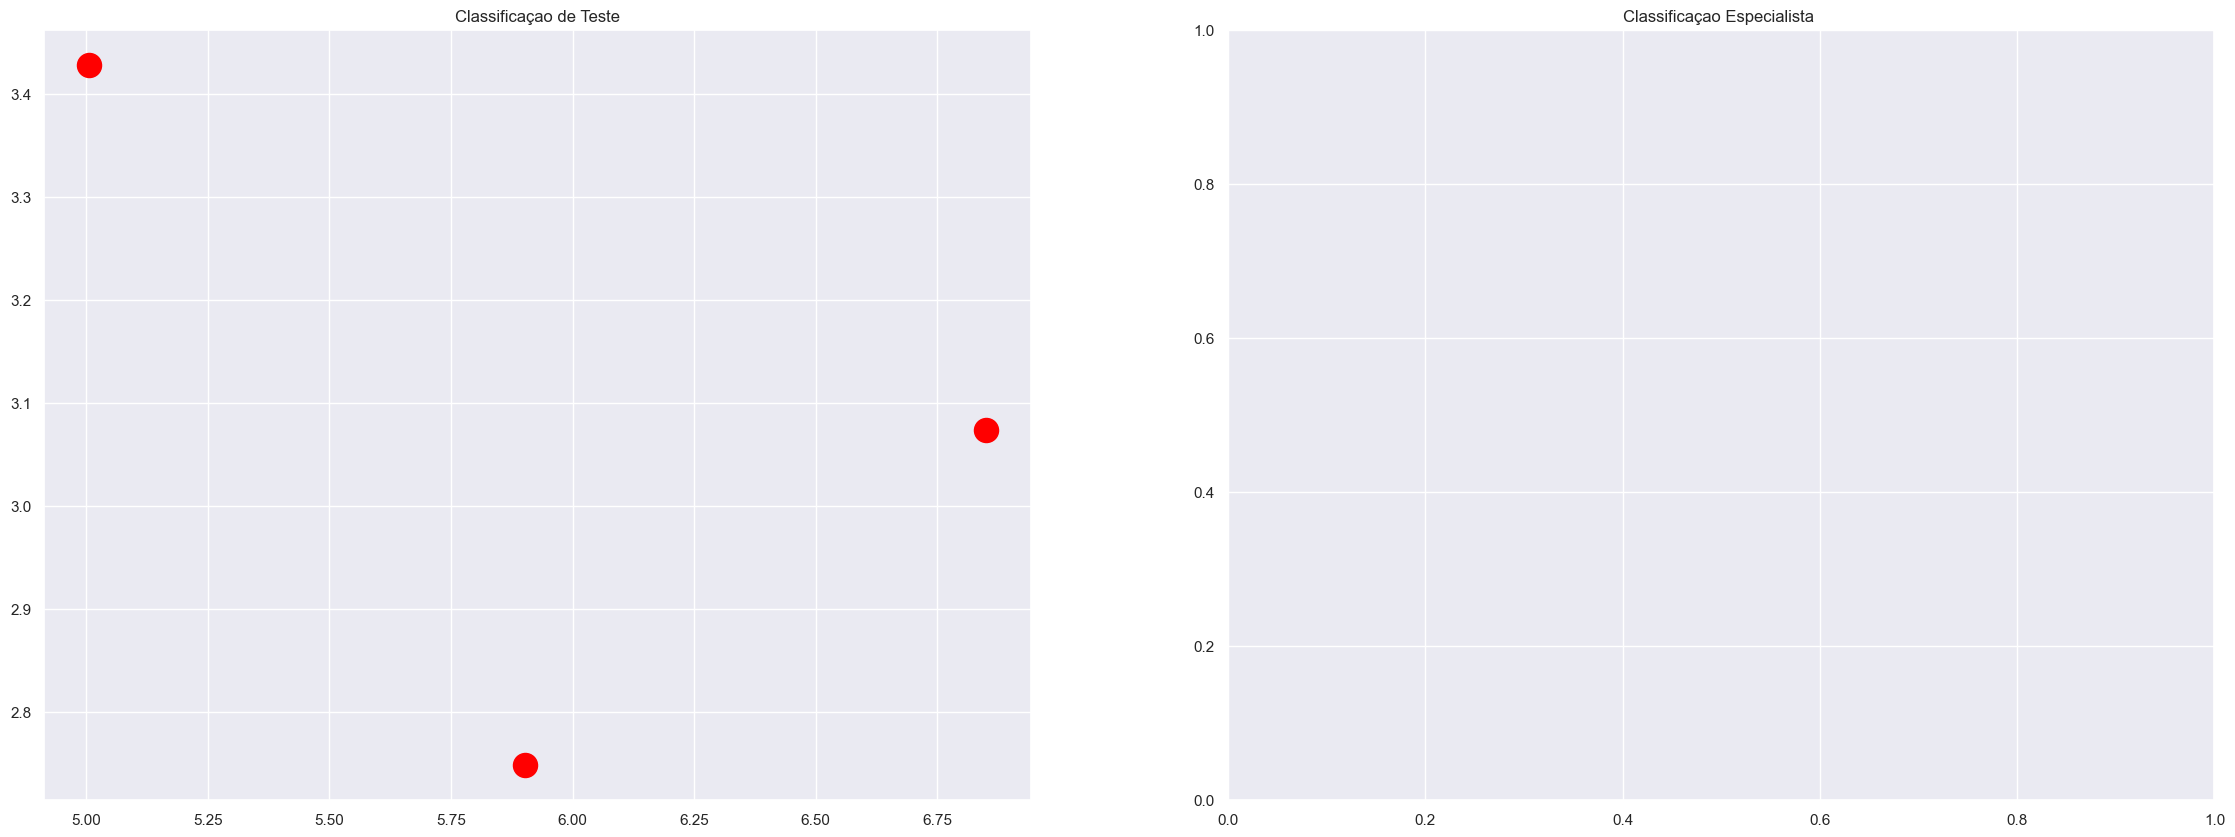

C:\Users\AbraaoCG\AppData\Local\Temp\ipykernel_14948\498439888.py:18: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data= iris_data_Teste_agrupado.loc[erros_Teste], x='sepal_length', y='sepal_width', ax=axe1, hue='Agrupamento' , palette = red_pallete_list ).set(title='Exibicao de erros em vermelho' )


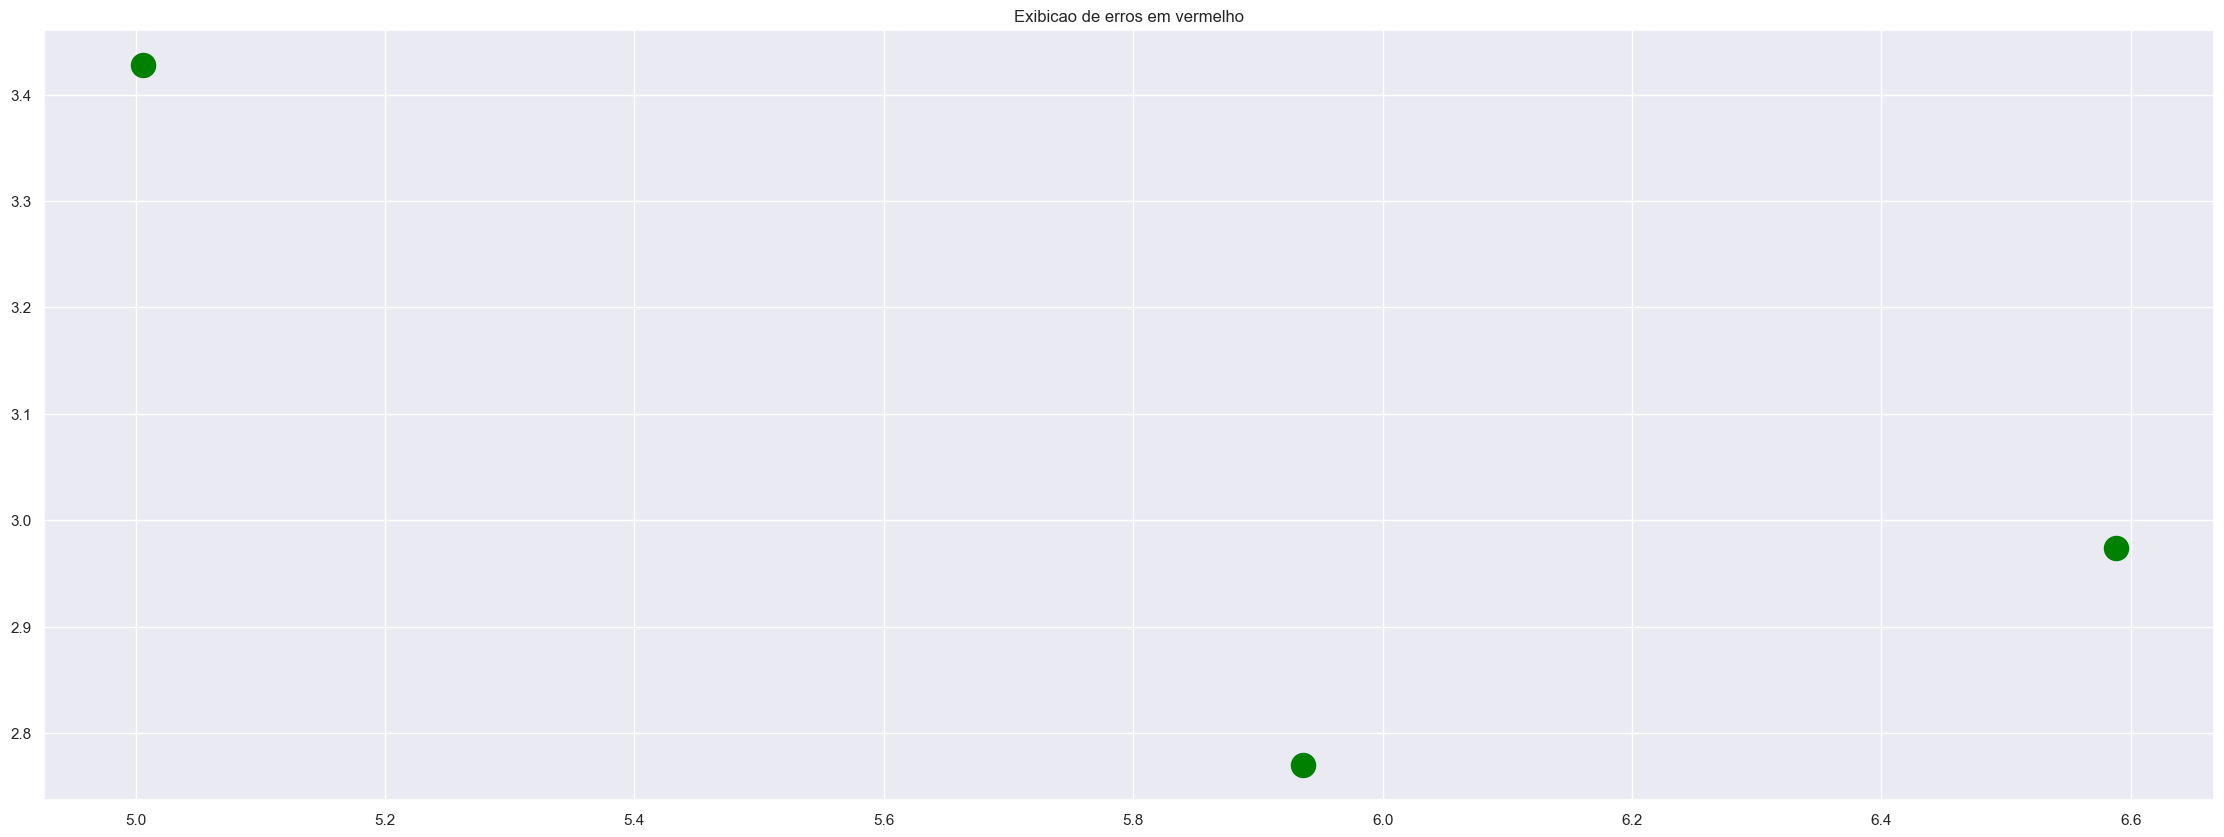

In [ ]:
# Plot da classificação do K Means com o segmento de Treino e Plot do dataset original com centroides criados a partir deste.
fig, (axe1, axe2) = plt.subplots(1,2, figsize=(28,10))

sns.scatterplot(data= iris_data_Teste_agrupado, x='sepal_length', y='sepal_width', hue='Agrupamento', ax=axe1).set(title='Classificaçao de Teste' )
axe1.scatter(x=x_center, y=y_center, s = 300, color='red')
sns.scatterplot(data= iris_data_Teste_agrupado , x='sepal_length', y='sepal_width', hue="species", ax=axe2).set(title='Classificaçao Especialista ')

#axe2.scatter(x=x_center_orig, y=y_center_orig, s = 300, color='green') ----> Centroides dataset Original.
plt.show()

red_pallete_list = []
for agrup in iris_data_Teste_agrupado.loc[erros_Teste]['Agrupamento'].unique():
  red_pallete_list.append('red')

fig, (axe1) = plt.subplots(1, figsize=(28,10))
sns.scatterplot(data= iris_data_Teste_agrupado, x='sepal_length', y='sepal_width', hue='Agrupamento', ax=axe1).set(title='Classificaçao de Teste' )
axe1.scatter(x=x_center_orig, y=y_center_orig, s = 300, color='green')
sns.scatterplot(data= iris_data_Teste_agrupado.loc[erros_Teste], x='sepal_length', y='sepal_width', ax=axe1, hue='Agrupamento' , palette = red_pallete_list ).set(title='Exibicao de erros em vermelho' )


plt.show()


In [ ]:
print(Centroide_original['Agrupam_correspondencia'])

setosa        1
versicolor    2
virginica     0
Name: Agrupam_correspondencia, dtype: int64


In [ ]:
iris_data_Treino.to_csv('dataset_treino.txt', sep = '\t', index =False)
iris_data_Teste.to_csv('dataset_teste.txt', sep = '\t', index =False)
Centroide_original.drop(['numObjetos','Agrupam_correspondencia'], axis = 1).to_csv('Centroide_Original.txt', sep = '\t', index =False, header=False)


In [ ]:
# Importar Centroides Gerados pelo treino do código proprietário.


tmp_char = ""
for label in headers_df:
    tmp_char = tmp_char + label + " "
fin = open("centrosFinal.txt", "rt")
fout = open("centrosFinal2.txt", "wt")
#Shift fortran bad format
fout.write(tmp_char + "\n")
for line in fin:
    tmp = line
    while(tmp[0] == " "):
        tmp = tmp[1:]
    fout.write(tmp)
fin.close()
fout.close()

centroides_Treino_Fortran = pd.read_csv('centrosFinal2.txt')
agrupamento_fortran = pd.read_csv('agrupamento.txt',sep=';')
agrupamento_fortran.index = iris_data_Treino.index
agrupamento_fortran.drop('Ponto', axis = 1,inplace = True)


type(centroides_Treino_Fortran[''])

FileNotFoundError: [Errno 2] No such file or directory: 'centrosFinal.txt'

In [ ]:
# Equivalencia de Grupo classificado e classificação real.
Centroide_original['Agrupam_correspondencia_fortran'] = -1

tmp1 = Centroide_original.drop(columns = ['numObjetos', 'Agrupam_correspondencia' ,'Agrupam_correspondencia_fortran'])

for orig_centr in Centroide_original.index.values:
  min_dist = np.Inf
  for classif_centr in centroides_Treino_Fortran.index.values:
    a = tmp1.loc[[orig_centr]].to_numpy()
    b = centroides_Treino_Fortran.iloc[[classif_centr]].to_numpy()
    dist_atual = np.linalg.norm( a  - b)
    if ( dist_atual <  min_dist ):
      min_dist = dist_atual
      minDist_label = classif_centr
  Centroide_original['Agrupam_correspondencia_fortran'][orig_centr] = minDist_label

print(" Equivalenência estimada entre agrupamento K Means e nome do grupo: ")
Centroide_original['Agrupam_correspondencia_fortran']

TypeError: unsupported operand type(s) for -: 'float' and 'str'

In [ ]:
# Cálculo de erro do Treino, caso seja conhecido o número de grupos original

erros_Treino_fortran = []
numErros_Treino_fortran = 0
for item in agrupamento_fortran.index.values:
  grupo_item = iris_data_Treino_avalia['species'][item]
  correspondencia_classif = Centroide_original['Agrupam_correspondencia_fortran'][ grupo_item ]
  if ( agrupamento_fortran['Grupo'][item] != correspondencia_classif ):
    #print(iris_data_Treino_avalia['Agrupamento'][item] , "      " , correspondencia_classif)
    erros_Treino_fortran.append(item)
    numErros_Treino_fortran += 1
print("Lista de Erros :" , erros_Treino_fortran)
print("Números de Erros : " , numErros_Treino_fortran)
print( "% de Erros : " , (numErros_Treino_fortran / ( tamData- numLinTeste ) ) * 100 , "%")


Lista de Erros : [0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70, 71, 72, 73, 74, 75, 77, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 90, 91, 92, 93, 94, 95, 96, 97, 98, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 112, 113, 114, 115, 116, 117, 118, 119, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149]
Números de Erros :  140
% de Erros :  97.9020979020979 %
